In [111]:
import os
import sys
import time
import copy

from collections import OrderedDict

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision import datasets

import PIL

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns

from livelossplot import PlotLosses

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import classification_report

from sklearn.metrics import mean_squared_error


from IPython.display import Image

from tqdm.notebook import tqdm



In [2]:
class RandomSphere(Dataset):
    
    """
    Class for generating dataset of a random
    sphere lying in a low dimensional manifold
    embedded in a higher dimensional space
    """
    
    def __init__(self, N=1000, num_neg=None, n=100, k=3, r=10.0, D=50.0, max_norm=100.0, mu=10, sigma=5, seed=42):
        
        """
        :param N: total number of samples
        :type N: int
        :param k: low (k-1)-dimensional manifold, embedded in k dims 
        :type k: int
        :param n: dimension of manifold in which sphere is embedded
        :type n: int
        :param r: radius of the sphere
        :type r: float
        :param D: clamping limit for negative examples
        :type D: float
        :return: points
        :param max_norm: maximum possible norm that a point can have
        :type max_norm: float
        :param mu: mean of normal distribution from which we sample
        :type: float
        :param sigma: standard deviation of normal distribution from which we sample
        :type: float
        :param seed: random seed (default is the answer to the ultimate question!)
        :type: int
        """
        
        self.N = N
        self.num_neg = np.floor(self.N / 2).astype(np.int64)
        if num_neg is not None:
            self.num_neg = num_neg
        self.n = n
        self.k = k
        self.r = r
        self.D = D
        self.max_norm = max_norm
        self.mu = mu
        self.sigma = sigma
        self.seed = seed
        
        ## setting seed
        torch.manual_seed(42)
        np.random.seed(42)
        
        self.x_ck = None
        """center of the sphere"""
        
        self.x_cn = None
        """center of sphere in higher dimension"""
        
        self.points_k = None
        """points sampled from the sphere in k-dim"""
        
        self.points_n = None
        """embedding of `self.points_k` in n-dim"""
        
        self.actual_distances = None
        """actual distance of points from the sphere's surface"""
        
        self.distances = None
        """clamped distance of the point from the sphere's surface"""
        
        
        self.translation = np.random.normal(self.mu, self.sigma, self.n)
        """randomly sampled translation transform"""
        
        self.rotation = np.random.normal(self.mu, self.sigma, (self.n, self.n))
        self.rotation = np.linalg.qr(self.rotation)[0]
        """randomly sampled rotation transform"""
        
        self.gen_center()
        print("center generated")
        self.gen_points()
        print("points generated")
        self.embed_in_n()
        print("embedding done")
#         self.compute_distances()
        
        self.points_n = torch.from_numpy(self.points_n).float()
        self.points_k = torch.from_numpy(self.points_k).float()
        self.distances = torch.from_numpy(self.distances).float()
        self.actual_distances = torch.from_numpy(self.actual_distances).float()
        
    def __len__(self):
        return self.points_n.shape[0]
    
    def __getitem__(self, idx):
        return self.points_n[idx], self.distances[idx]
        
        
    def gen_center(self):
        """generate a center in lower dimension"""
        self.x_ck = np.random.normal(self.mu, self.sigma, self.k)
        
    def gen_points(self):
        """generating points in k-dim and embedding in n-dim"""
        points_k = np.random.normal(self.mu, self.sigma, (self.N, self.k))
        points_k = points_k - self.x_ck
        
        norms = np.linalg.norm(points_k, axis=1, ord=2).reshape(-1, 1)
        points_k = (points_k / norms)
        
#         print(np.round(np.linalg.norm(points_k, axis=1, ord=2))[np.ceil(np.linalg.norm(points_k, axis=1, ord=2)) > 1])
        
        assert (np.round(np.linalg.norm(points_k, axis=1, ord=2)) == 1).all()
        
        points_k = self.r * points_k
        
#         neg_norms = np.random.uniform(low=1 + np.finfo(np.float).eps,\
#                                       high=self.max_norm, size=np.floor(self.N / 2).astype(np.int64))
        
#         points_k[:np.floor(self.N / 2).astype(np.int64)] = (neg_norms.reshape(-1, 1) / self.r) * points_k[:np.floor(self.N / 2).astype(np.int64)]
        
        points_k = points_k + self.x_ck
        
        self.points_k = points_k
        
    def make_neg_examples(self):
        """generating negative examples, i.e., points not on the manifold"""
        
        # normal_vectors_to_mfld_at_p are actually centred at x_ck, but 
        # we can imaging the same vector at $p$, and later adjust the coordinates
        # by adding the position vector of $p$ back.
        #
        # Also note that these negative examples are being generated using first
        # half of self.points_k
        normal_vectors_to_mfld_at_p = self.points_k[:self.num_neg] - self.x_ck
        embedded_normal_vectors_to_mfld_at_p = np.zeros((self.num_neg, self.n))
        embedded_normal_vectors_to_mfld_at_p[:, :self.k] = normal_vectors_to_mfld_at_p
        
        neg_examples = np.zeros((self.num_neg, self.n))
        neg_distances = np.zeros(self.num_neg)
        
        # canonical basis $e_i$ over leftover dimensions
        remaining_dims = self.n - self.k
        leftover_basis = np.eye(remaining_dims)
        
        # variable to store spanning set
        span_set = np.zeros((remaining_dims + 1, self.n))
        span_set[1:, self.k:] = leftover_basis
        
        
        for i in tqdm(range(self.num_neg)):

            n_cap = embedded_normal_vectors_to_mfld_at_p[i]
            
            # span set is n_cap and leftover basis
            span_set[0] = n_cap
            

            # sample random coefficients
#             coefficients = np.random.uniform(-1 * self.max_norm, self.max_norm, span_set.shape[0])
            coefficients = np.random.uniform(self.mu, self.sigma, span_set.shape[0])

            # take linear combination
            neg_examples[i] = np.sum(coefficients.reshape(-1, 1) * span_set, axis=0)
            
        # re-scale with random norms
#         neg_norms = np.random.uniform(low=-1 * self.max_norm, high=self.max_norm, size=self.num_neg)
        neg_norms = np.random.normal(self.mu, self.sigma, size=self.num_neg)

        neg_examples = (neg_norms.reshape(-1, 1) / np.linalg.norm(neg_examples, axis=1, ord=2).reshape(-1, 1)) * neg_examples

        # add position vector of $p$ to get origin centered coordinates
        neg_examples[:, :self.k] = neg_examples[:, :self.k] + self.points_k[:self.num_neg]

        # distances from the manifold will be the norms the samples were rescaled by
        neg_distances = neg_norms
        
        return neg_examples, neg_norms
            
    
    
    def embed_in_n(self):
        
        # embedding the center
        self.x_cn = np.zeros(self.n)
        self.x_cn[:self.k] = self.x_ck
        self.x_cn = self.x_cn + self.translation         
        
        # generate the negative examples
        neg_examples, neg_distances = self.make_neg_examples()
        
        #embedding the points
        points_n = np.zeros((self.N, self.n))
        points_n[:self.num_neg] = neg_examples
        
        points_n[self.num_neg:, :self.k] = self.points_k[self.num_neg:]
        self.points_n = points_n + self.translation
        
        self.actual_distances = np.zeros((self.N, 1))
        self.actual_distances[:self.num_neg] = neg_distances.reshape(-1, 1)
        self.actual_distances[self.num_neg:] = np.linalg.norm(self.points_n[self.num_neg:] - self.x_cn, axis=1, ord=2).reshape(-1, 1) - self.r
        self.distances = np.clip(self.actual_distances, a_min=0, a_max=self.D)
        
        assert (np.round(np.linalg.norm(self.points_n[self.num_neg:] - self.x_cn, axis=1, ord=2)) == self.r).all()
    

    
    

In [3]:
class MLP(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_sizes=[512, 512, 512, 512]):
        
        super(MLP, self).__init__()
        
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        
        layers = [("fcn-0", nn.Linear(self.input_size, hidden_sizes[0])), ("relu-0", nn.ReLU())]
        
        for i in range(len(hidden_sizes) - 1):

            layers.append(("fcn-{n}".format(n=i+1), nn.Linear(hidden_sizes[i], hidden_sizes[i+1])))
            layers.append(("relu-{n}".format(n=i+1), nn.ReLU()))
                    
        layers.append(("fcn-" + str(len(hidden_sizes)), nn.Linear(hidden_sizes[-1], output_size)))
        
        self.layers = nn.Sequential(OrderedDict(layers))
        
    def forward(self, X):
        
        logits = self.layers(X)
        return logits

In [52]:
class ConvNet1(nn.Module):
    """CNN-based architecture"""
    
    
    def __init__(self, input_size, output_size):
        
        super(ConvNet1, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.conv_1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=2)
        self.bn_1 = nn.BatchNorm1d(16)
        self.conv_2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=2)
        self.bn_2 = nn.BatchNorm1d(16)
        self.maxpool_1 = nn.MaxPool1d(kernel_size=2)
        self.dp_1 = nn.Dropout(0.2)
        
        
        
        
        self.blk_out = nn.Sequential(OrderedDict([
            ("fc-1", nn.Linear(in_features=16 * 124, out_features=1))
        ]))
        
    def forward(self, X):
#         print(X.shape)
        X = X.view(X.shape[0], 1, -1)
#         print(X.shape)

        logits = self.conv_1(X)
        logits = self.bn_1(logits)
        logits = self.conv_2(logits)
        logits = self.bn_2(logits)
        logits = self.maxpool_1(logits)
        logits = self.dp_1(logits)
#         print(logits.shape)
        logits = logits.view(logits.shape[0], -1)
        logits = self.blk_out(logits)
        
        return logits

In [64]:
class ConvNet2(nn.Module):
    """CNN-based architecture"""
    
    
    def __init__(self, input_size, output_size):
        
        super(ConvNet2, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.conv_11 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=2)
        self.bn_11 = nn.BatchNorm1d(32)
        self.conv_12 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=2)
        self.bn_12 = nn.BatchNorm1d(32)
        self.maxpool_11 = nn.MaxPool1d(kernel_size=2)
        self.dp_11 = nn.Dropout(0.2)
        
        self.conv_21 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=2)
        self.bn_21 = nn.BatchNorm1d(16)
        self.conv_22 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=2)
        self.bn_22 = nn.BatchNorm1d(16)
        self.maxpool_21 = nn.MaxPool1d(kernel_size=2)
        self.dp_21 = nn.Dropout(0.5)
        
        
        
        
        self.blk_out = nn.Sequential(OrderedDict([
            ("fc-1", nn.Linear(in_features=16 * 15, out_features=1))
        ]))
        
    def forward(self, X):
#         print(X.shape)
        X = X.view(X.shape[0], 1, -1)
#         print(X.shape)

        logits = self.conv_11(X)
        logits = self.bn_11(logits)
        logits = self.conv_12(logits)
        logits = self.bn_12(logits)
        logits = self.maxpool_11(logits)
        logits = self.dp_11(logits)
        
        logits = self.conv_21(logits)
        logits = self.bn_21(logits)
        logits = self.conv_22(logits)
        logits = self.bn_22(logits)
        logits = self.maxpool_21(logits)
        logits = self.dp_21(logits)
        
#         print(logits.shape)
        logits = logits.view(logits.shape[0], -1)
        logits = self.blk_out(logits)
        
        return logits

In [22]:
def train(model, optimizer, loss, dataloaders, device,\
          num_epochs, save_dir, name="MLP_512x4_in1000",\
          scheduler={"start_iter": 150, "end_iter": 500}):
    """
        Function to train the model. Also dumps the best model.
        
        Returns the best model and optimizers

    """
    
    # storing the start_lr
    start_lr = None
    for param_group in optimizer.param_groups:
        start_lr = param_group['lr']
    
    TIME_STAMP = time.strftime("%d%m%Y-%H%M%S")

    
    model_dir = os.path.join(save_dir, "models")
    plot_dir = os.path.join(save_dir, "plots")
    
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(plot_dir, exist_ok=True)
    
    plot_fn = os.path.join(plot_dir, name + "_" + TIME_STAMP)
    
    liveloss = PlotLosses(fig_path=plot_fn)
    
    phase = "train"
    
    last_best_epoch_loss = None
    
    for epoch in tqdm(range(num_epochs)):
        
        logs = {
            "loss": 0,
            "val_loss": 0
        }
        
        
        
        for phase in ["train", "val"]:
            
            dl = dataloaders[phase]
            
            if phase == "train":
                torch.set_grad_enabled(True)
                model.train()
            else:
                torch.set_grad_enabled(False)
                model.eval()
            
            num_batches = 0
            
            prefix = ""
            if phase == "val":
                prefix = "val_"
            
            for (i, batch) in enumerate(dataloaders[phase]):
                
                points = batch[0].to(device)
                distances = batch[1].to(device)
                
                model.zero_grad()
                model = model.to(device)
                
                logits = model(points)
                
                loss = loss_func(distances, logits)
                
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                    
                logs[prefix + "loss"] += loss.detach().cpu().item()
                
                num_batches = i
                
                points = points.cpu()
                distances = distances.cpu()
                model = model.cpu()
            
            # dividing by the number of batches
            logs[prefix + "loss"] /= num_batches
            
        if last_best_epoch_loss is None or logs["val_loss"] < last_best_epoch_loss:
            last_best_epoch_loss = logs["val_loss"]
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': logs['val_loss'],
                'loss': logs["loss"]
            }, os.path.join(model_dir, NAME + "_"+ TIME_STAMP + "val_loss_" + str(logs["val_loss"]) + ".pth"))
        
        if scheduler is not None:
            
            if epoch > scheduler["start_iter"]:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = start_lr - (((0 - start_lr) / (scheduler["start_iter"] - scheduler["end_iter"])) * epoch)
        
        
        liveloss.update(logs)
        liveloss.draw()
        
    return models, optimizer
            
            


In [71]:
def test(model, dataloader, device):
    
    model.eval()
    
    all_logits = None
    all_distances = None
    
    with torch.no_grad():
        
        for batch in tqdm(dataloader):
            
            points = batch[0].to(device)
            distances = batch[1]
            
            model.zero_grad()
            model = model.to(device)

            logits = model(points).detach().cpu()

            points = points.cpu()
            distances = distances.cpu()
            model = model.cpu()
            
            if all_logits is None:
                all_logits = logits
            else:
                all_logits = torch.cat((all_logits, logits))
            
            if all_distances is None:
                all_distances = distances
            else:
                all_distances = torch.cat((all_distances, distances))
            
    
    mse = mean_squared_error(all_distances, all_logits)
    mse_on_mfld = mean_squared_error(all_distances[np.round(all_distances) == 0], all_logits[np.round(all_distances) == 0])
    
    
    
    print("MSE for the learned distances:", mse)
    print("MSE for the learned distances (on-manifold):", mse_on_mfld)
    return mse, mse_on_mfld, all_distances, all_logits
    
    # TODO: fix this for concentric dataset
    
            

In [24]:
train_params = {
    "N": 100000,
    "num_neg": None,
    "n": 1000,
    "k": 2,
    "r": 100.0,
    "D": 200.0,
    "max_norm": 500.0,
    "mu": 1000,
    "sigma": 5000,
    "seed": 23
}

val_params = {
    "N": 50000,
    "num_neg": None,
    "n": 1000,
    "k": 2,
    "r": 100.0,
    "D": 200.0,
    "max_norm": 500.0,
    "mu": 1000,
    "sigma": 5000,
    "seed": 101
}

test_params = {
    "N": 100000,
    "num_neg": None,
    "n": 1000,
    "k": 2,
    "r": 100.0,
    "D": 200.0,
    "max_norm": 500.0,
    "mu": 1000,
    "sigma": 5000,
    "seed": 89
}

train_set = RandomSphere(**train_params)
val_set = RandomSphere(**val_params)
test_set = RandomSphere(**test_params)


center generated
points generated



embedding done
center generated
points generated



embedding done
center generated
points generated



embedding done


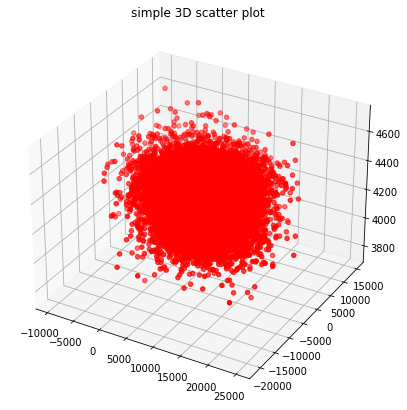

In [110]:
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 

# tmp = np.einsum('ij,kj->ki',Q,train_set.points_n)

# Creating dataset
z = train_set.points_n[5000:, 2]
x = train_set.points_n[5000:, 0]
y = train_set.points_n[5000:, 1]

neg_samples = np.random.choice(np.arange(0, 5000), size=1000)
z_neg = train_set.points_n[neg_samples, 2]
x_neg = train_set.points_n[neg_samples, 0]
y_neg = train_set.points_n[neg_samples, 1]

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax1 = plt.axes(projection ="3d")

# Creating plot

ax1.scatter3D(x, y, z, color="red")
# ax1.scatter3D(x_neg, y_neg, z_neg, color="green", marker="^")

plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

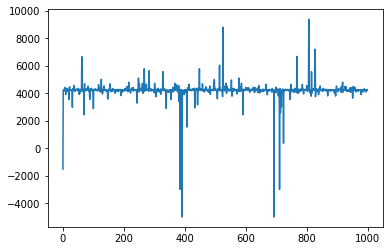

In [78]:
plt.plot(z_neg)

In [10]:
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 

tmp = np.einsum('ij,kj->ki',Q,train_set.points_n)
# Creating dataset
z = tmp[5000:, 2]
x = tmp[5000:, 0]
y = tmp[5000:, 1]

z_neg = tmp[neg_samples, 2]
x_neg = tmp[neg_samples, 0]
y_neg = tmp[neg_samples, 1]

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax1 = plt.axes(projection ="3d")

# Creating plot

ax1.scatter3D(x, y, z, color="red")
ax1.scatter3D(x_neg, y_neg, z_neg, color="green", marker="^")


plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

NameError: name 'Q' is not defined

In [26]:
BATCH_SIZE = 2048
NUM_WORKERS = 9

dataloaders = {
    "train": DataLoader(dataset=train_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS),
    "val": DataLoader(dataset=val_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS),
    "test": DataLoader(dataset=test_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
}

In [27]:
train_set.points_n.shape

torch.Size([100000, 1000])

In [65]:
model = ConvNet2(input_size=1000, output_size=1)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), weight_decay=0.005, lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NAME = "ConvNet2_in1000_o1"
SAVE_DIR = "../dumps/expB_learning_distance_from_mfld"

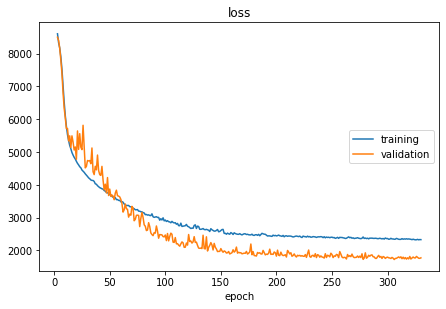

loss:
training   (min: 2323.985, max: 10555.532, cur: 2329.586)
validation (min: 1723.790, max: 9727.112, cur: 1774.823)


KeyboardInterrupt: 

In [66]:
model, optimizer = train(model, optimizer, loss_func, dataloaders, device, num_epochs=10000, save_dir=SAVE_DIR, name=NAME)



In [98]:
mse, mse_on_mfld, all_distances, all_logits = test(model, dataloaders["test"], device)


MSE for the learned distances: 1719.3748
MSE for the learned distances (on-manifold): 578.3985


In [103]:

distances = all_distances.reshape(-1)[np.round(all_distances.reshape(-1), decimals=3) == 0]
logits = all_logits.reshape(-1)[np.round(all_distances.reshape(-1), decimals=3) == 0]

errors = torch.sqrt((distances - logits) ** 2)


Text(0.5, 1.0, 'error dist. for 2-dim mfld. embedded in 1000 dim space')

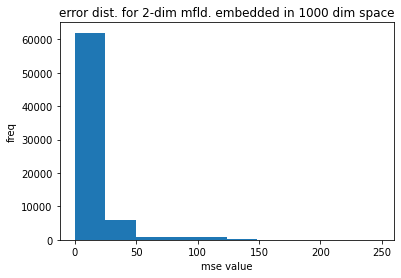

In [114]:
plt.hist(errors.numpy())
plt.xlabel("mse value")
plt.ylabel("freq")
plt.title("error dist. for 2-dim mfld. embedded in 1000 dim space")

# Trying to learn distance from multiple spheres

## Concentric Spheres

In [97]:
class ConcentricSpheres(Dataset):
    
    """
    Class for generating dataset of concentric random
    spheres lying in a low dimensional manifold
    embedded in a higher dimensional space
    
    Note: no explicit -ve examples. Points on one sphere are
    negative examples for the other
    """
    
    def __init__(self, num_spheres=2, N=[1000, 1000],
                 n=100, k=3, r=[10.0, 20.0], D=[50.0, 55.0],
                 mu=10, sigma=5, seed=42):
        
        """
        :param num_spheres: total number of spheres
        :type num_spheres: int
        :param N: total number of samples per sphere
        :type N: list[int]
        :param k: low (k)-dimensional manifold 
        :type k: int
        :param n: dimension of manifold in which sphere is embedded
        :type n: int
        :param r: radii of the spheres
        :type r: list[float]
        :param D: list of clamping limits for negative examples
        :type D: list[float]
        :return: points
        :param mu: mean of normal distribution from which we sample
        :type: float
        :param sigma: standard deviation of normal distribution from which we sample
        :type: float
        :param seed: random seed (default is the answer to the ultimate question!)
        :type: int
        """
        
        self.num_spheres = num_spheres
        self.N = N
        self.n = n
        self.k = k
        self.r = r
        self.D = D
        self.mu = mu
        self.sigma = sigma
        self.seed = seed
        
        ## setting seed
        torch.manual_seed(42)
        np.random.seed(42)
        
        self.x_ck = None
        """center of the sphere"""
        
        self.x_cn = None
        """center of sphere in higher dimension"""
        
        self.points_k = None
        """points sampled from the sphere in k-dim"""
        
        self.points_n = None
        """embedding of `self.points_k` in n-dim"""
        
        self.actual_distances = None
        """actual distance of points from the sphere's surface"""
        
        self.distances = None
        """clamped distance of the point from the sphere's surface"""
        
        
        self.translation = np.random.normal(self.mu, self.sigma, self.n)
        """randomly sampled translation transform"""
        
        
        self.gen_center()
        self.gen_points()
        self.embed_in_n()
        self.compute_distances()
        
        self.points_n = torch.from_numpy(self.points_n).float()
        self.points_k = torch.from_numpy(self.points_k).float()
        self.distances = torch.from_numpy(self.distances).float()
        self.actual_distances = torch.from_numpy(self.actual_distances).float()
        
    def __len__(self):
        return self.points_n.shape[0]
    
    def __getitem__(self, idx):
        return self.points_n[idx], self.distances[idx]
        
        
    def gen_center(self):
        """generate a center for both spheres in lower dimension"""
        self.x_ck = np.random.normal(self.mu, self.sigma, self.k)
        
    def gen_points(self):
        """generating points in k-dim and embedding in n-dim"""
        
        for i in range(self.num_spheres):
            
            points_k = np.random.normal(self.mu, self.sigma, (self.N[i], self.k))
            points_k = points_k - self.x_ck

            norms = np.linalg.norm(points_k, axis=1, ord=2).reshape(-1, 1)
            points_k = (points_k / norms)

    #         print(np.round(np.linalg.norm(points_k, axis=1, ord=2))[np.ceil(np.linalg.norm(points_k, axis=1, ord=2)) > 1])

            assert (np.round(np.linalg.norm(points_k, axis=1, ord=2)) == 1).all()

            points_k = self.r[i] * points_k


            if self.points_k is None:
                self.points_k = points_k
            else:
                self.points_k = np.vstack((self.points_k, points_k))
        
        self.points_k = self.points_k + self.x_ck
        
        assert (np.round(np.linalg.norm(self.points_k - self.x_ck, axis=1, ord=2)) == np.array(sum([[self.r[i] for j in range(self.N[i])] for i in range(self.num_spheres)], []))).all()

    
    def embed_in_n(self):
        
        # embedding the center
        self.x_cn = np.zeros(self.n)
        self.x_cn[:self.k] = self.x_ck
        self.x_cn = self.x_cn + self.translation         
        
        #embedding the points
        tmp = [0] + self.N
        for i in range(1, len(tmp)):
            points_n = np.zeros((tmp[i], self.n))
            points_n[:, :self.k] = self.points_k[tmp[i-1]:tmp[i-1]+tmp[i]]
            if self.points_n is None:
                self.points_n = points_n
            else:
                self.points_n = np.vstack((self.points_n, points_n))
        
        self.points_n = self.points_n + self.translation
        assert (np.round(np.linalg.norm(self.points_n - self.x_cn, axis=1, ord=2)) == np.array(sum([[self.r[i] for j in range(self.N[i])] for i in range(self.num_spheres)], []))).all()

        
    def compute_distances(self):
        
        self.actual_distances = np.linalg.norm(self.points_n - self.x_cn, axis=1, ord=2).reshape(-1, 1) - self.r
        self.distances = np.clip(self.actual_distances, a_min=0, a_max=self.D)
        


In [98]:
conc_train_params = {
    "num_spheres": 2,
    "N": [100000, 100000],
    "n": 1000,
    "k": 3,
    "r": [10.0, 20.0],
    "D": [50.0, 80.0],
    "mu": 10,
    "sigma": 5,
    "seed": 42
}

conc_val_params = {
    "num_spheres": 2,
    "N": [50000, 50000],
    "n": 1000,
    "k": 3,
    "r": [10.0, 20.0],
    "D": [50.0, 80.0],
    "mu": 10,
    "sigma": 5,
    "seed": 101
}


conc_test_params = {
    "num_spheres": 2,
    "N": [50000, 50000],
    "n": 1000,
    "k": 3,
    "r": [10.0, 20.0],
    "D": [50.0, 80.0],
    "mu": 10,
    "sigma": 5,
    "seed": 79
}


conc_train_set = ConcentricSpheres(**conc_train_params)
conc_val_set = ConcentricSpheres(**conc_val_params)
conc_test_set = ConcentricSpheres(**conc_ test_params)


In [99]:
BATCH_SIZE = 2048
NUM_WORKERS = 9

dataloaders = {
    "train": DataLoader(dataset=conc_train_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS),
    "val": DataLoader(dataset=conc_val_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS),
    "test": DataLoader(dataset=conc_test_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
}

In [100]:
model = MLP(input_size=1000, output_size=2)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), weight_decay=0.005, lr=1e-3)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NAME = "MLP_in1000_H512x4_o2_conc"
SAVE_DIR = "../dumps/expB_learning_distance_from_mfld"

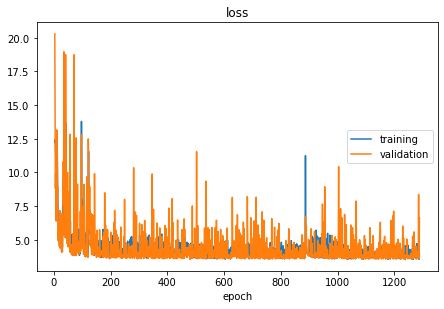

loss:
training   (min:    3.537, max:   13.792, cur:    3.950)
validation (min:    3.547, max:   20.301, cur:    6.640)


KeyboardInterrupt: 

In [101]:
model, optimizer = train(model, optimizer, loss_func, dataloaders, device, num_epochs=10000, save_dir=SAVE_DIR, name=NAME, scheduler=-0.5)


In [163]:
np.sum(np.arange(2, 4).reshape(-1, 1) * np.ones((2, 3)), axis=0)




array([5., 5., 5.])

In [104]:
np.arange(2, 5).reshape(-1, 1) / np.arange(2, 5).reshape(-1, 1)

array([[1.],
       [1.],
       [1.]])

In [11]:
A = np.random.randn(3, 3)

In [12]:
Q = np.linalg.qr(A)[0]

<AxesSubplot:>

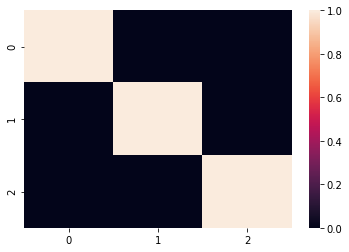

In [289]:
sns.heatmap(np.dot(Q, Q.T))

In [290]:
U, S, V = np.linalg.svd(A, full_matrices=False)

In [291]:
U.shape

(3, 3)

<AxesSubplot:>

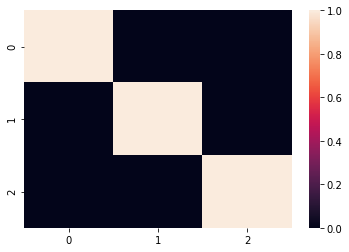

In [292]:
sns.heatmap(np.dot(U, U.T))

In [293]:
np.linalg.matrix_rank(A)

3

In [294]:
np.dot(Q, Q.T)

array([[ 1.00000000e+00,  3.11103894e-16, -7.46346366e-18],
       [ 3.11103894e-16,  1.00000000e+00,  1.38632026e-16],
       [-7.46346366e-18,  1.38632026e-16,  1.00000000e+00]])